In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext notexbook
%texify

In [2]:
from narsil2.mm.segmentation import load_net, segment_cells_dir, segment_all_positions, MMDataTest, segment_channels_dir
from narsil2.segmentation.transformations import OmniTestTransformations, UnetTestTransformations
from narsil2.mm.segmentation import cut_channels_all_positions, cut_fluor_all_positions, cut_fluor_one_position
from narsil2.mm.segmentation import cut_channels_one_position
from narsil2.fish.transformations import FishTransformations
from narsil2.mm.tracking import process_all_positions, process_one_position
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [3]:
root_dir = '/mnt/sda2/Praneeth/ASTFISH/'

phase_main_dir = root_dir + 'data/EXP-22-BV6196 AST FISH 220214/The rule'
analysis_dir = root_dir + 'analysis_rev/EXP-22-BV6196 AST FISH 220214/'
genotype_dir = root_dir + 'data/EXP-22-BV6196 AST FISH 220214/Genotype'
positions = list(range(101, 181)) + list(range(201, 281))
#positions = [101]

#### Model paths

In [4]:
cell_seg_path = '../../saved_models/omnipose_mm_old_new_320_long.ckpt'
channel_seg_path = '../../saved_models/channels.pth'
tracker_model_path = '../../saved_models/tracker_model.pth'
fish_model_path = '../../saved_models/seven_species_debugged.joblib'

### Segmentation

In [5]:

segmentation_parameters = {
    'fileformat': "*.tiff",
    'seg_method': {
        'cells': 'omnipose',
        'channels': 'unet'
    },
    'cell_transforms': OmniTestTransformations(return_tensors=True, shrink_half=False),
    'channel_transforms': UnetTestTransformations(return_tensors=True,
                                                  shrink_half=False,
                                                  pad_to=16,
                                                  add_noise=True,
                                                  flip=False),
    'channel_add_noise': True,
    'clean_mask': False,
    'cell_prob_threshold': 0.3,
    'channel_seg_threshold': 0.7,
    'min_size': 400,
    'save_seg_mask': True,
    'save_channel_seg_mask': False,
    'save_seg_dir': None,
    'model_paths': {
        'cells': cell_seg_path,
        'channels': channel_seg_path,
    },
    'segmentation_devices': {
        'cells': 'cuda:1', # cell net takes more space so you will have to run it on cuda:1
        'channels': 'cuda:0' # channel net is smaller so you can run it independently in a different process.
    },
    'channel_cutting_params': {
        'channel_min': 600,
        'channel_max': 1200,
        'channel_sum': 300,
        'hist_peaks_distance': 90,
        'minimum_barcode_distance': 160,
        'num_channels': 16,
        'first_barcode_index': 10,
    },
    'flip_positions': range(201, 281),
    'analysis_dir': analysis_dir,
    'write_dir_names': {
        'cell_seg_raw': 'segmented_phase',
        'channel_seg_raw': 'segmented_channels',
        'channel_stacks' : 'blobs',
        'fluor_stacks': 'fish_channels',
    },
    'dir_names': {
        'phase': 'phase'
    },
    'cutting_and_writing_params' : {
        'num_images': 35,
        'channel_width': 80,
        'cut_until_frames': 35,
        
    }
    
}

#### Uncomment and run the next cell to do segmentation

In [6]:
#segment_all_positions(phase_main_dir, segmentation_parameters, positions)

In [7]:
fluorescence_parameters = {
    'channel_names': ['alexa488', 'cy3', 'cy5', 'texasred'],
    'channel_width': 80,
    'flip_positions': range(201, 281),
    'transform': FishTransformations(return_tensors=False, pad_to=16, shrink_half=False, flip=False),
    'phase_img_to_map': 'img_000000034.tiff', # ususally the last image in the stack,
    'equalize': None,
    'analysis_dir': analysis_dir,
    'write_dir_names': {
        'fluor_stacks': 'fish_channels',
    },
    'genotype_dir': genotype_dir, 
}

#### Cut channels and write channel stacks

In [8]:
#cut_channels_all_positions(analysis_dir, positions, segmentation_parameters)

#### Cut fluor channels and write them

In [9]:
#cut_fluor_all_positions(analysis_dir, positions, fluorescence_parameters)

#### Tracking and Growth calculations

In [10]:
tracking_parameters = {
    'move_iou_thres': 0.15,
    'div_iou_thres' : 0.15,
    'write_dir_names': {
        'channel_stacks': 'blobs',
        'growth_rates': 'growth_rates',
        'fluor_stacks': 'fish_channels',
    },
    'growth_type': 'rolling', # or 'ratio'
    'net_path': tracker_model_path,
    'species_map': {
        'ecoli': ['cy3'],
        'kpneumoniae': ['cy3', 'cy5'],
        'paeruginosa': ['alexa488', 'texasred'],
        'efaecalis': ['alexa488', 'cy5'],
        'abaumanii': ['alexa488', 'cy3'],
        'pmirbalis': ['alexa488'],
        'saureus': ['cy5', 'texasred'],
    },
    'background_channel_no': 15,
    'flip_positions': range(201, 281),
    'num_channels': 32,
    'growth_type': 'rolling'
}
fluor_parameters = {
    'channel_names':  ['alexa488', 'cy3', 'cy5', 'texasred'],
    'classifier_path': fish_model_path,
    'normalization_vector': np.array([4326.27224687, 4310.09326905, 4197.56158149, 4275.67799421]),
    'smooth': True,
}
positions = list(range(101, 181)) + list(range(201, 281))


In [11]:
#analysis_position_dir = Path(analysis_dir) / 'Pos201'

In [12]:
#process_one_position(analysis_position_dir, tracking_parameters, fluor_parameters, process_type='double')

#### Track, assign species and write growth rates

In [13]:
#process_all_positions(Path(analysis_dir), positions,
#                    tracking_parameters, fluor_parameters,
#                    process_type='double')

### Growth rates plots

In [14]:
from narsil2.mm.growth import growth_rate_pickles


In [15]:
species_names = ['ecoli', 'kpneumoniae', 'paeruginosa', 'efaecalis', 'abaumanii', 'pmirbalis', 'saureus']
species_titles = ['E.coli', 'K.pneumoniae', 'P.aeruginosa', 'E.faecalis', 'A.baumannii', 'P.mirbalis', 'S.aureus']
No_Ab_Positions = list(range(101, 181))
Ab_Positions = list(range(201, 281))

In [16]:
g = growth_rate_pickles(Path(analysis_dir), species_names, species_titles,
                        No_Ab_Positions=No_Ab_Positions, Ab_Positions=Ab_Positions,
                        tracking_parameters=tracking_parameters,
                        antibiotic_concentration=4,
                        antibiotic_name='Gentamycin',
                       n_frames=30)

In [17]:
species_full_names = {
    'ecoli':'E.coli',
    'kpneumoniae':'K.pneumoniae',
    'paeruginosa':'P.aeruginosa',
    'efaecalis':'E.faecalis',
    'abaumanii':  'A.baumannii',
    'pmirbalis': 'P.mirabilis',
    'saureus': 'S.aureus',
}

In [18]:
color_scheme = {
    'paeruginosa': 'c',
    'abaumanii': 'g',
}

##### Careful, you can only ignore some species if there are not many cells of the species.
You need to verify it before plotting. You will have loaded 2 species, but the species assignment has some errors, you will have to check this for every experiment to make sure the classifier to good and is doing it's job

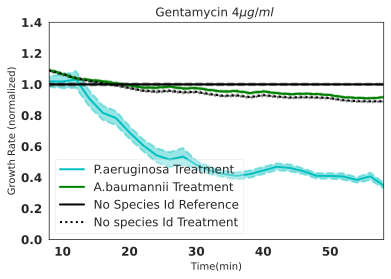

In [19]:
g.plot_species_wise_and_pooled(color_scheme=color_scheme,
                               ignore=['ecoli','kpneumoniae' , 'efaecalis', 'pmirbalis', 'saureus'],
                              species_full_name=species_full_names)

In [20]:
g.No_Ab_Clean_GrowthRates

{'ecoli': (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),
 'kpneumoniae': (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),
 'paeruginosa': (array([0.        , 0.        , 0.        , 0.        , 0.01827557,
         0.01698337, 0.01666849, 0.01673699, 0.016

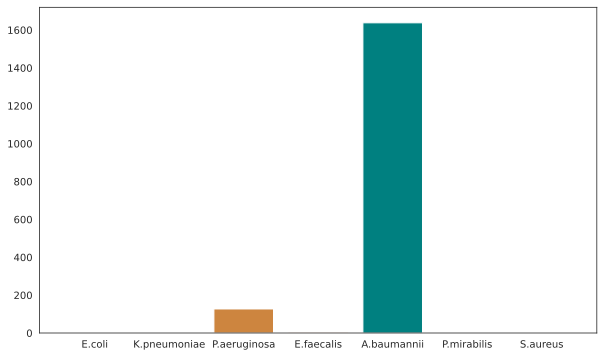

In [21]:
labels_to_colors = {
    0: 'deeppink', # E.coli
    1: 'gold', # k.pneumoniae
    2: 'peru', # p.aeruginosa
    3: 'orangered', # e.faecalis
    4: 'teal', # A.baumanni
    5: 'silver', # p.mirabalis
    6: 'royalblue', # s.aureus 
    7: 'k' # background
}

labels = {
    0: 'E.coli',
    1: 'K.pneumoniae',
    2: 'P.aeruginosa',
    3: 'E.faecalis',
    4: 'A.baumannii',
    5: 'P.mirabilis',
    6: 'S.aureus',
    7: 'Background'
}
species_to_color = {
    'E.coli': 0,
    'K.pneumoniae': 1,
    'P.aeruginosa': 2,
    'E.faecalis': 3,
    'A.baumannii': 4,
    'P.mirabilis': 5,
    'S.aureus': 6,
}

species_list = []
species_counts = []
colors = []
for species in g.No_Ab_Clean_GrowthRates:
    species_list.append(species_full_names[species])
    species_counts.append(g.No_Ab_Clean_GrowthRates[species][2][4])
    colors.append(labels_to_colors[species_to_color[species_full_names[species]]])
plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.bar(np.arange(len(species_list)), species_counts, color=colors)
plt.xticks(np.arange(len(species_list)), species_list)
plt.show()